In [1]:
import madmom
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [2]:
uploaded_file_name = "Referencni_skladby/Imanbek & BYOR - Belly Dancer (Official Music Video).wav"
# uploaded_file_name = "Referencni_skladby/The Beatles - Abbey Road (1969) (2012 180g Vinyl 24bit-96kHz) [FLAC] vtwin88cube/07.-Here Comes The Sun.wav"
# uploaded_file_name = "Referencni_skladby/The Beatles - Abbey Road (1969) (2012 180g Vinyl 24bit-96kHz) [FLAC] vtwin88cube/01.-Come Together.wav"

# Beat tracking

In [3]:
y, sr = librosa.load(uploaded_file_name)
tempo_librosa, beats = librosa.beat.beat_track(y=y, sr=sr)
onset_env = librosa.onset.onset_strength(y=y, sr=sr, aggregate=np.median)
times = librosa.times_like(onset_env, sr=sr, hop_length=512)
beats = times[beats]
times

array([0.00000000e+00, 2.32199546e-02, 4.64399093e-02, ...,
       1.53483900e+02, 1.53507120e+02, 1.53530340e+02])

In [4]:
beats_stength = np.ones(len(beats))

In [5]:
i = 0
for beat in beats:
    try:
        index = np.where(times == beat)[0]
        beats_stength[i] = onset_env[index][0]
    except ValueError:
        beats_stength[i] = 0
    i += 1

In [6]:
beats_stength = librosa.util.normalize(beats_stength)

In [7]:
beats = np.expand_dims(beats, axis=0)
beats =np.vstack((beats,beats_stength))

Text(-0.08, 0.5, 'b)')

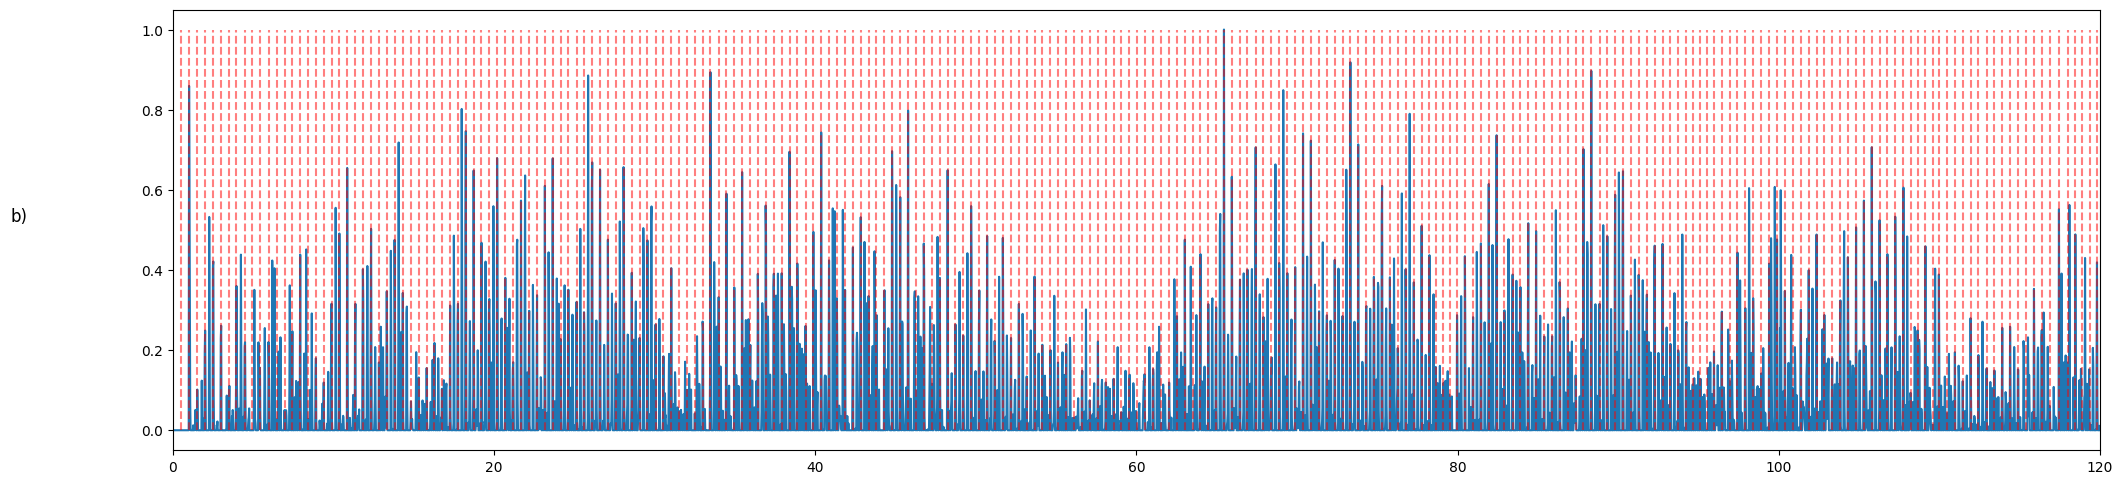

In [8]:
xmin_time = 0 # Čas skladby, oa kterého se vykreslí grafy.
xmax_time = 120 # Čas skladby, do kterého se vykreslí grafy.
fig, ax = plt.subplots(1,1, figsize=(20,5))
fig.tight_layout()
fig.subplots_adjust(hspace = 0.6 )

ax.plot(times, librosa.util.normalize(onset_env))
ax.vlines(beats[0], 0, 1, alpha=0.5, color='r', linestyle='--')
ax.set_xlim(xmin=xmin_time, xmax=xmax_time)
ax.set_title('b)', x=-0.08,y=0.5)

# Chroma Features

In [9]:
# Chroma librosa

y, sr = librosa.load(uploaded_file_name)

y_harm = librosa.effects.harmonic(y=y, margin=8)

chroma_harm = librosa.feature.chroma_cqt(y=y_harm, sr=sr)
chroma_filter = np.minimum(chroma_harm, librosa.decompose.nn_filter(chroma_harm, aggregate=np.median, metric= 'cosine'))
chroma_smooth = scipy.ndimage.median_filter(chroma_filter, size=(1,9))

np.shape(chroma_smooth)

(12, 6613)

In [10]:
# Chroma madmom
# FPS Něco dělá

dcp = madmom.audio.DeepChromaProcessor()
chroma_madmom_deep = dcp(data = uploaded_file_name,fps = 20.751)
chroma_madmom = np.transpose(chroma_madmom_deep)
np.shape(chroma_madmom)

(12, 6612)

In [11]:
# chroma_smooth_b = (chroma_smooth > 0.6).astype(int)
chroma_smooth_b = (chroma_madmom > 0.6).astype(int)

chroma_smooth_b

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Text(87.72222222222221, 0.5, 'výška tónu')

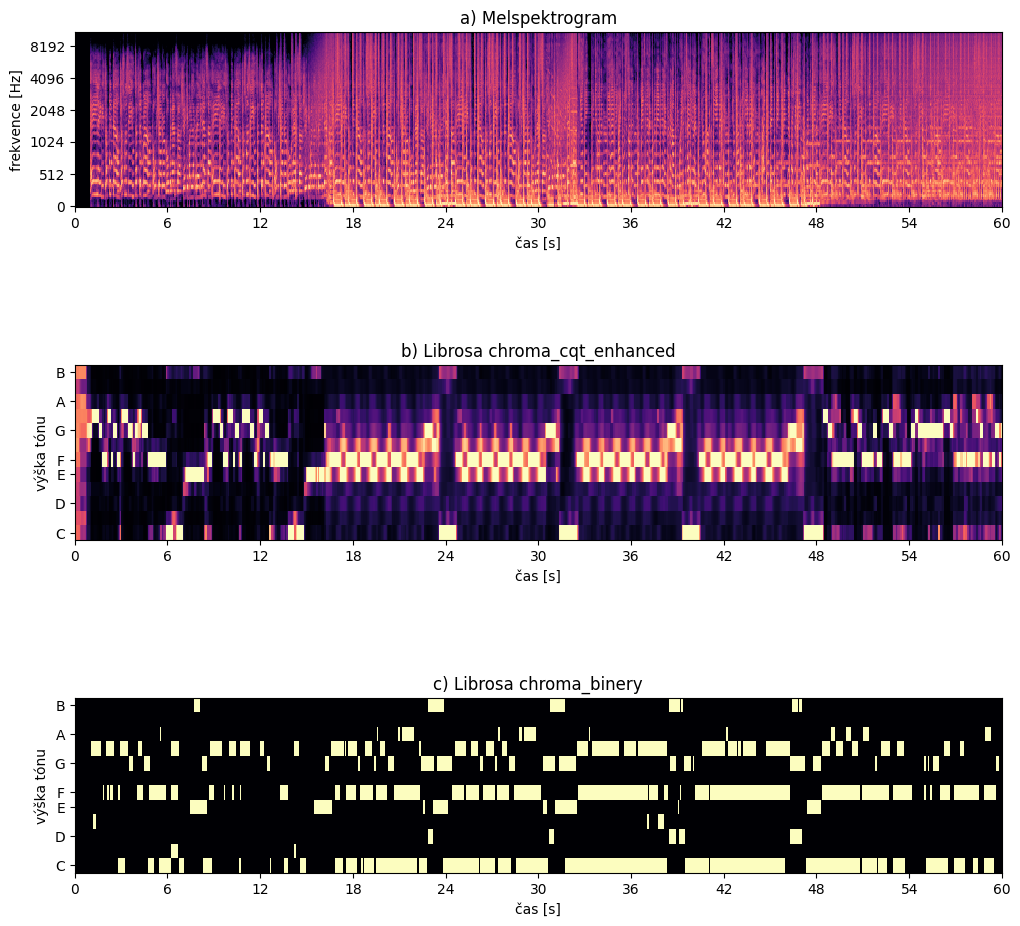

In [12]:
xmin_time = 0; # Čas skladby, oa kterého se vykreslí grafy.
xmax_time = 60; # Čas skladby, do kterého se vykreslí grafy.
fig, ax = plt.subplots(3,1, figsize=(10,9))
fig.tight_layout()
fig.subplots_adjust(hspace = 0.9 )

hop_length = 512

y, sr = librosa.load(uploaded_file_name)
M = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length)
librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                        y_axis='mel', x_axis='time', hop_length=hop_length,
                        ax=ax[0])

ax[0].set_title('a) Melspektrogram')
ax[0].set_xlim(xmin=xmin_time, xmax=xmax_time)
ax[0].set_xlabel("čas [s]")
ax[0].set_ylabel("frekvence [Hz]")


img = librosa.display.specshow(chroma_smooth, y_axis='chroma', x_axis='time', ax=ax[1])
ax[1].set_xlim(xmin=xmin_time, xmax=xmax_time)
ax[1].set_title("b) Librosa chroma_cqt_enhanced")
ax[1].set_xlabel("čas [s]")
ax[1].set_ylabel("výška tónu")

librosa.display.specshow(chroma_smooth_b, y_axis='chroma', x_axis='time', ax=ax[2])
ax[2].set_xlim(xmin=xmin_time, xmax=xmax_time)
ax[2].set_title("c) Librosa chroma_binery")
ax[2].set_xlabel("čas [s]")
ax[2].set_ylabel("výška tónu")


In [13]:
suma = np.sum(chroma_smooth_b, axis=1)
suma

array([4560,   74,  280,   32,  841, 3935,    0, 1230, 1740,  948,    0,
        514])

In [14]:
import colorsys

In [15]:
def generate_triadic_colors(hue, saturation=0.85, lightness=0.5):
    """Generuje triadické barvy zadané HSL hodnoty."""
    # Správná syntaxe pro list comprehension
    colors_hsl = [((hue + i * 120) % 360, saturation, lightness) for i in range(3)]
    colors_rgb = [colorsys.hls_to_rgb(h/360.0, lightness, saturation) for h, s, l in colors_hsl]
    # Převedení RGB z rozsahu 0-1 na 0-255
    colors_rgb = [(int(r * 255), int(g * 255), int(b * 255)) for r, g, b in colors_rgb]
    colors_rgb = np.array(colors_rgb)
    return colors_rgb

# Generujeme triadické barvy
hue = np.random.randint(0, 360)  # Náhodný odstín
triadic_colors = generate_triadic_colors(hue)

print("Triadické barvy (RGB):", triadic_colors)

Triadické barvy (RGB): [[235 206  19]
 [ 19 235 206]
 [206  19 235]]


In [16]:
most_played_tones = [0,0,0]
sum_c = np.copy(suma)

for i in range(3):
    most_played_tones[i] = np.argmax(sum_c)
    sum_c[most_played_tones[i]] = 0

most_played_tones

[0, 5, 8]

In [17]:
tones_colors = np.zeros(shape=(12,3), dtype=int)
tones_colors

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [18]:
for i in range(3):
    tones_colors[most_played_tones[i]] = triadic_colors[i]

tones_colors

array([[235, 206,  19],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [ 19, 235, 206],
       [  0,   0,   0],
       [  0,   0,   0],
       [206,  19, 235],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0]])

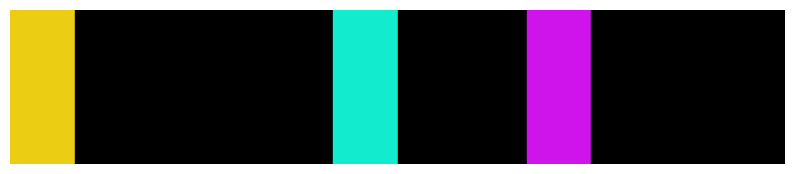

In [19]:
fig, ax = plt.subplots(1, figsize=(10, 2))

# Pro každou barvu vytvoříme obdélník a přidáme ho do grafu
for i, barva in enumerate(tones_colors):
    # Vytvoření obdélníku pro každou barvu
    # Pozice a velikost obdélníku jsou určeny tak, aby všechny barvy byly vedle sebe
    rect = plt.Rectangle((i, 0), 1, 1, color=barva/255)  # Normalizace RGB hodnot do rozsahu 0-1
    ax.add_patch(rect)

# Nastavení os pro zobrazení všech obdélníků
ax.set_xlim(0, 12)
ax.set_ylim(0, 1)
ax.axis('off')  # Vypnutí os, abychom viděli jen barvy

plt.show()

In [20]:
def Color_shift(old_color, i):
    old_color_hsv = colorsys.rgb_to_hsv(r=old_color[0],g=old_color[1],b=old_color[2])
    new_color_hsv = list(old_color_hsv)
    new_color_hsv[0] = (new_color_hsv[0] + (i * 15)/360.0)
    new_color = colorsys.hsv_to_rgb(new_color_hsv[0],new_color_hsv[1], new_color_hsv[2])
    new_color = [int(new_color[0]), int(new_color[1]), int(new_color[2])]
    return new_color

for i in range (12):
    for n in range (3):
        try:
            if np.sum(tones_colors[most_played_tones[n]-i]) == 0 and (most_played_tones[n]-i) >= 0:
                tones_colors[most_played_tones[n]-i] = Color_shift(triadic_colors[n],i)
                # tones_colors[most_played_tones[n]-i] = np.rint(triadic_colors[n] * (1-(i*0.08))).astype(int)
        except IndexError:
            continue
    
        try:
            if np.sum(tones_colors[most_played_tones[n]+i]) == 0:
                tones_colors[most_played_tones[n]+i] = Color_shift(triadic_colors[n],i)
                # tones_colors[most_played_tones[n]+i] = np.rint(triadic_colors[n] * (1-(i*0.08))).astype(int)

        except IndexError:
            continue

In [21]:
print(tones_colors)

[[235 206  19]
 [210 235  19]
 [155 235  19]
 [ 19 156 235]
 [ 19 209 235]
 [ 19 235 206]
 [ 19 209 235]
 [235  19 210]
 [206  19 235]
 [235  19 210]
 [235  19 156]
 [235  19 102]]


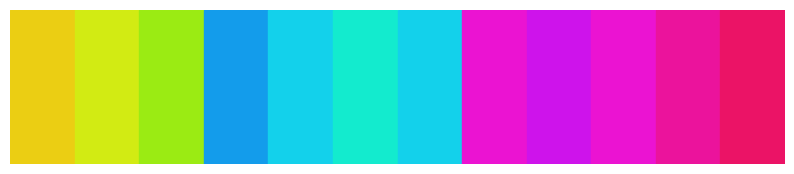

In [22]:
fig, ax = plt.subplots(1, figsize=(10, 2))

# Pro každou barvu vytvoříme obdélník a přidáme ho do grafu
for i, barva in enumerate(tones_colors):
    # Vytvoření obdélníku pro každou barvu
    # Pozice a velikost obdélníku jsou určeny tak, aby všechny barvy byly vedle sebe
    rect = plt.Rectangle((i, 0), 1, 1, color=barva/255)  # Normalizace RGB hodnot do rozsahu 0-1
    ax.add_patch(rect)

# Nastavení os pro zobrazení všech obdélníků
ax.set_xlim(0, 12)
ax.set_ylim(0, 1)
ax.axis('off')  # Vypnutí os, abychom viděli jen barvy

plt.show()